<a href="https://colab.research.google.com/github/Remonah-3/Github_Assignment/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Init 1 iteration 4 Converged
Init 2 iteration 5 Converged
Init 3 iteration 3 Converged
Init 4 iteration 2 Converged
Init 5 iteration 2 Converged
Best SSE: 48.63378320706403


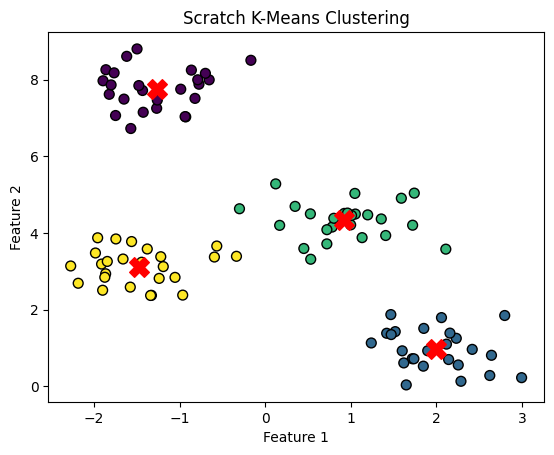

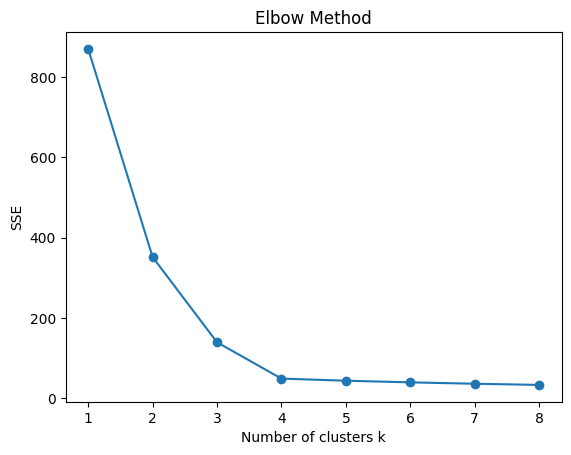

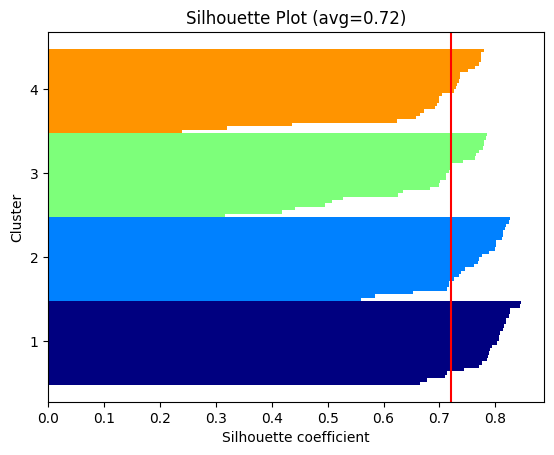

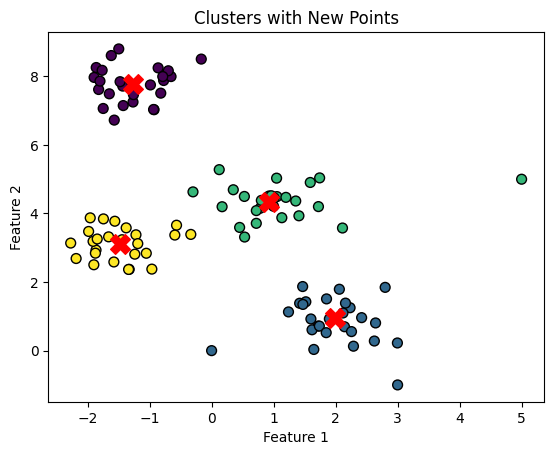

Explained variance ratio by PCA: [0.45961362 0.40517227]
Init 1 iteration 17 Converged
Init 2 iteration 32 Converged
Init 3 iteration 6 Converged
Init 4 iteration 8 Converged
Init 5 iteration 28 Converged
Best SSE: 59089638200.42679


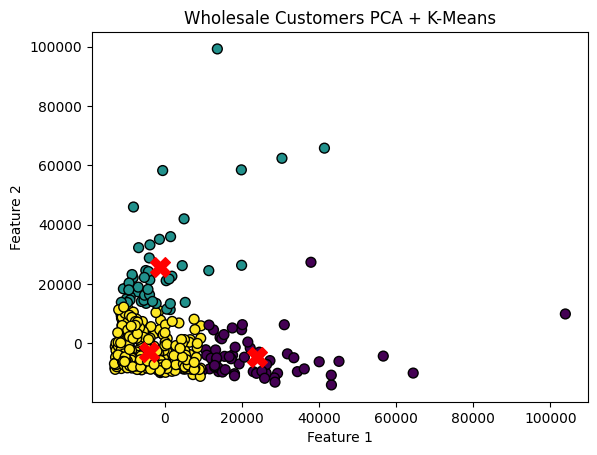

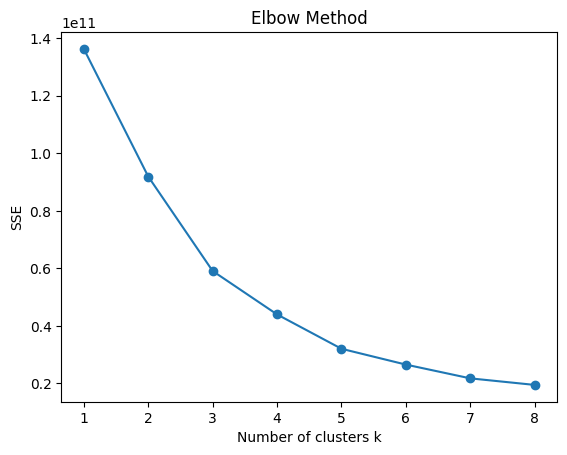

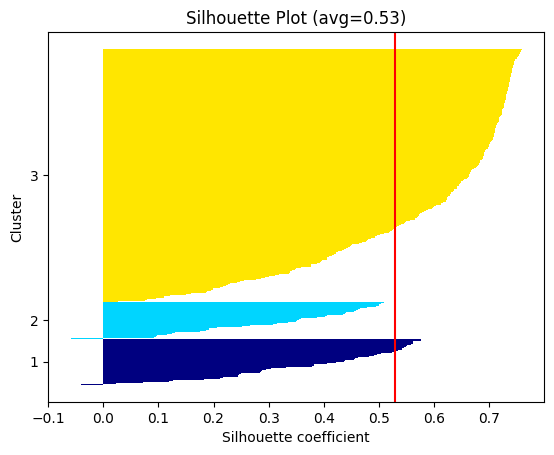

Cluster distribution vs Region:
Region   1   2    3
row_0              
0       11   4   45
1       10   8   31
2       56  35  240

Cluster distribution vs Channel:
Channel    1   2
row_0           
0         52   8
1          2  47
2        244  87

Average spending per cluster:
                Fresh          Milk       Grocery       Frozen  \
Cluster                                                          
0        35941.400000   6044.450000   6288.616667  6713.966667   
1         8149.836735  18715.857143  27756.591837  2034.714286   
2         8230.528701   3838.709970   5320.761329  2565.290030   

         Detergents_Paper   Delicassen  
Cluster                                 
0             1039.666667  3049.466667  
1            12523.020408  2282.142857  
2             1788.063444  1136.404834  


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from matplotlib import cm

class ScratchKMeans:
    def __init__(self, n_clusters=3, n_init=10, max_iter=100, tol=1e-4, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.centers = None
        self.labels = None
        self.inertia_ = None  # SSE of best clustering

    # Compute SSE
    def _compute_sse(self, X, centers, labels):
        sse = 0.0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            sse += np.sum((cluster_points - centers[k])**2)
        return sse

    # Assign clusters to nearest center
    def _assign_clusters(self, X, centers):
        labels = np.zeros(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            distances = np.linalg.norm(x - centers, axis=1)
            labels[i] = np.argmin(distances)
        return labels

    # Update cluster centers to mean of assigned points
    def _update_centers(self, X, labels):
        centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            if np.any(labels == k):
                centers[k] = X[labels == k].mean(axis=0)
        return centers

    # Fit the model to X
    def fit(self, X):
        best_sse = np.inf
        best_centers = None
        best_labels = None

        for init_no in range(self.n_init):
            # Initialize centers randomly
            centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
            for iteration in range(self.max_iter):
                old_centers = centers.copy()
                labels = self._assign_clusters(X, centers)
                centers = self._update_centers(X, labels)
                shift = np.sum((centers - old_centers)**2)
                if shift < self.tol:
                    if self.verbose:
                        print("Init", init_no+1, "iteration", iteration, "Converged")
                    break
            # Keep clustering with smallest SSE
            sse = self._compute_sse(X, centers, labels)
            if sse < best_sse:
                best_sse = sse
                best_centers = centers
                best_labels = labels

        self.centers = best_centers
        self.labels = best_labels
        self.inertia_ = best_sse
        if self.verbose:
            print("Best SSE:", self.inertia_)

    # Predict cluster labels for new data points
    def predict(self, X):
        return self._assign_clusters(X, self.centers)

# Visualization functions

# Plot clusters with centers
def plot_clusters(X, labels, centers=None, title="Clusters"):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Elbow method to choose k
def elbow_method(X, max_k=10):
    sse_list = []
    for k in range(1, max_k+1):
        km = ScratchKMeans(n_clusters=k, n_init=5, max_iter=100)
        km.fit(X)
        sse_list.append(km.inertia_)
    plt.plot(range(1, max_k+1), sse_list, marker='o')
    plt.xlabel("Number of clusters k")
    plt.ylabel("SSE")
    plt.title("Elbow Method")
    plt.show()
    return sse_list

# Silhouette plot
def silhouette_plot(X, labels):
    n_clusters = len(np.unique(labels))
    silhouette_vals = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        same_cluster = X[labels == labels[i]]
        other_clusters = [X[labels == k] for k in range(n_clusters) if k != labels[i]]
        a = np.mean(np.linalg.norm(same_cluster - X[i], axis=1))
        b = np.min([np.mean(np.linalg.norm(cluster - X[i], axis=1)) for cluster in other_clusters])
        silhouette_vals[i] = (b - a) / max(a, b)
    silhouette_avg = np.mean(silhouette_vals)

    y_lower = 0
    yticks = []
    for i, c in enumerate(np.unique(labels)):
        c_vals = silhouette_vals[labels == c]
        c_vals.sort()
        y_upper = y_lower + len(c_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_lower, y_upper), c_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_lower + y_upper) / 2)
        y_lower = y_upper

    plt.axvline(silhouette_avg, color="red")
    plt.yticks(yticks, np.unique(labels)+1)
    plt.xlabel("Silhouette coefficient")
    plt.ylabel("Cluster")
    plt.title("Silhouette Plot (avg=" + str(round(silhouette_avg, 2)) + ")")
    plt.show()

# Test on artificial data

X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, random_state=0)

kmeans_scratch = ScratchKMeans(n_clusters=4, n_init=5, max_iter=100, verbose=True)
kmeans_scratch.fit(X)

plot_clusters(X, kmeans_scratch.labels, kmeans_scratch.centers, "Scratch K-Means Clustering")
elbow_method(X, max_k=8)
silhouette_plot(X, kmeans_scratch.labels)

# Predict new points
new_points = np.array([[0, 0], [5, 5], [3, -1]])
new_labels = kmeans_scratch.predict(new_points)
plot_clusters(np.vstack([X, new_points]), np.hstack([kmeans_scratch.labels, new_labels]), kmeans_scratch.centers, "Clusters with New Points")

# Wholesale Customers dataset
data = pd.read_csv("Wholesale customers data.csv")

# Remove 'Region' and 'Channel' for clustering
monetary_data = data.drop(columns=['Region', 'Channel'])

# PCA for 2D visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(monetary_data)
print("Explained variance ratio by PCA:", pca.explained_variance_ratio_)

# Fit KMeans on PCA-reduced data
kmeans_wholesale = ScratchKMeans(n_clusters=3, n_init=5, max_iter=100, verbose=True)
kmeans_wholesale.fit(data_pca)

plot_clusters(data_pca, kmeans_wholesale.labels, kmeans_wholesale.centers, "Wholesale Customers PCA + K-Means")

# Problem 10: Choosing k (Elbow and Silhouette)
elbow_method(data_pca, max_k=8)
silhouette_plot(data_pca, kmeans_wholesale.labels)

# Problem 11: Compare clusters with known groups
# Region is known group, Channel is not used
print("Cluster distribution vs Region:")
print(pd.crosstab(kmeans_wholesale.labels, data['Region']))
print("\nCluster distribution vs Channel:")
print(pd.crosstab(kmeans_wholesale.labels, data['Channel']))

# Problem 12: Useful information for wholesalers
cluster_summary = monetary_data.copy()
cluster_summary['Cluster'] = kmeans_wholesale.labels
summary_stats = cluster_summary.groupby('Cluster').mean()
print("\nAverage spending per cluster:")
print(summary_stats)

#Problem 10
We first prepared the monetary data from the Wholesale Customers dataset by removing non-numeric columns and reducing it to two dimensions using PCA for easy visualization.

We then used the elbow method to calculate and plot the sum of squared errors (SSE) for different numbers of clusters
$𝑘$, identifying the point where SSE stops decreasing sharply as a candidate for the optimal $
k$.

To further confirm, we used the silhouette method, which measures how well each point fits into its assigned cluster; higher average silhouette scores indicate better clustering.

By examining both the elbow plot and silhouette plot, we chose k = 3 because it shows a clear elbow in SSE and a reasonably high silhouette score, meaning the clusters are distinct, well-separated, and meaningful for segmenting customers.

# Problem 11
When comparing the K-means clusters to the known Region and Channel groups, we see that the clusters do not perfectly align with these categories.

Customers from the same region can belong to different clusters, and some clusters include customers from multiple regions, showing that K-means is grouping based on spending patterns, not geography.

Similarly, while some clusters partially correspond to the Channel (retail vs. wholesale), there is overlap, meaning Channel alone does not define the clusters. Overall, the clusters highlight differences in purchasing behavior across the six product categories, revealing meaningful customer segments that are not captured by Region or Channel labels.

#Problem 12
By examining the clusters using the original six features, wholesalers can see clear differences in customer spending patterns.

For example, Cluster 0 consists of customers who spend heavily on Fresh products, Cluster 1 has high spending on Milk, Grocery, and Detergents_Paper, and Cluster 2 shows generally lower spending across all categories.

This information can help wholesalers target marketing, promotions, and inventory management according to customer behavior rather than just region or channel.

For instance, they might offer special deals on Fresh products to Cluster 0 customers or focus on Milk and Grocery promotions for Cluster 1.

Understanding these behavior-based segments allows wholesalers to tailor strategies more effectively, improve customer satisfaction, and optimize sales.

# Problem 13: Advantages/Disadvantages
DBSCAN advantages:
 - Can find clusters of any shape, not just spherical.
 - Automatically detects noise points.

 Disadvantages:
 - Hard to choose parameters (eps and min_samples).
 - Not suitable for clusters with very different densities.

t-SNE and LLE advantages:
- Good for visualizing high-dimensional data in 2D/3D.
- Captures local structure well.

Disadvantages:
- t-SNE is slow for large datasets and results can vary each run.
- LLE may not work well if data is noisy.

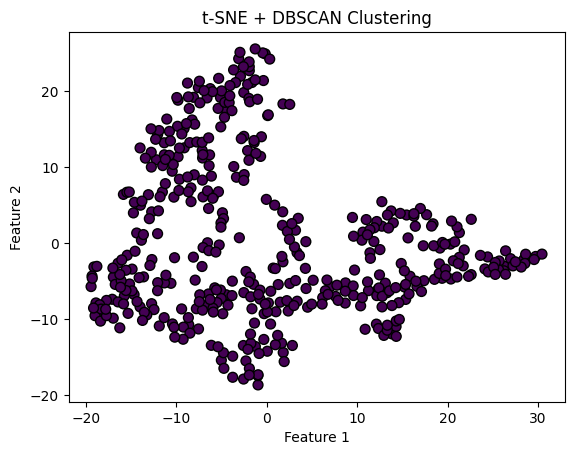

DBSCAN cluster counts: (array([0]), array([440]))


In [7]:
# t-SNE + DBSCAN on Wholesale Customers

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(monetary_data)

# DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_tsne)

# Plot t-SNE + DBSCAN clusters
plot_clusters(data_tsne, dbscan_labels, title="t-SNE + DBSCAN Clustering")

# Compare DBSCAN with KMeans clusters
print("DBSCAN cluster counts:", np.unique(dbscan_labels, return_counts=True))
